In [1]:
import os
import pandas as pd
import numpy as np
import pydicom
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import cv2
import glob

In [2]:
!unzip -q /kaggle/input/lsdc-gen-yolo-data-scs/data_fold4.zip

In [3]:
ls

__notebook__.ipynb  data_fold4/


In [4]:
IMG_DIR = "/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images"

In [5]:
FOLD = 4
OD_INPUT_SIZE = 384
STD_BOX_SIZE = 20
BATCH_SIZE = 64
EPOCHS = 50

SAMPLE = None
CONDITIONS = ['Spinal Canal Stenosis']
SEVERITIES = ['Normal/Mild', 'Moderate', 'Severe']
LEVELS = ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']

DATA_DIR = f'data_fold{FOLD}'



In [6]:
# rm -rf val_fold0

In [7]:
train_val_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
train_xy = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
train_des = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [8]:
if SAMPLE:
    train_val_df = train_val_df.sample(SAMPLE, random_state=2698)

In [9]:
fold_df = pd.read_csv('/kaggle/input/lsdc-fold-split/5folds.csv')

In [10]:
train_xy.head(3)

,study_id,series_id,instance_number,condition,level,x,y
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182


In [11]:
def get_level(text):
    for lev in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
        if lev in text:
            split = lev.split('_')
            split[0] = split[0].capitalize()
            split[1] = split[1].capitalize()
            return '/'.join(split)
    raise ValueError('Level not found '+ lev)
    
def get_condition(text):
    split = text.split('_')
    for i in range(len(split)):
        split[i] = split[i].capitalize()
    split = split[:-2]
    return ' '.join(split)
#     raise ValueError('Condition not found '+ lev)

In [12]:
train_xy['condition'].unique()

array(['Spinal Canal Stenosis', 'Right Neural Foraminal Narrowing',
       'Left Neural Foraminal Narrowing', 'Left Subarticular Stenosis',
       'Right Subarticular Stenosis'], dtype=object)

In [13]:
# train_df = train_df.dropna()

In [14]:
label_df = {'study_id':[], 'condition': [], 'level':[], 'label':[]}

for i, row in train_val_df.iterrows():
    study_id = row['study_id']
    for k, label in row.iloc[1:].to_dict().items():
        level = get_level(k)
        condition = get_condition(k)
        label_df['study_id'].append(study_id)
        label_df['condition'].append(condition)
        label_df['level'].append(level)
        label_df['label'].append(label)
#         break
#     break

label_df = pd.DataFrame(label_df)
label_df = label_df.merge(fold_df, on='study_id')

In [15]:
train_xy = train_xy.merge(train_des, how='inner', on=['study_id', 'series_id'])
label_df = label_df.merge(train_xy, how='inner', on=['study_id', 'condition', 'level'])

In [16]:
def query_train_xy_row(study_id, series_id=None, instance_num=None):
    if series_id is not None and instance_num is not None:
        return label_df[(label_df.study_id==study_id) & (label_df.series_id==series_id) &
            (label_df.instance_number==instance_num)]
    elif series_id is None and instance_num is None:
        return label_df[(label_df.study_id==study_id)]
    else:
        return label_df[(train_xy.study_id==study_id) & (label_df.series_id==series_id)]

In [17]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

def get_accronym(text):
    split = text.split(' ')
    return ''.join([x[0] for x in split])

In [18]:
# study_id = 4003253 
# series_id = 2448190387
# instance_num = 28

ex = label_df.sample(1).iloc[0]
study_id = ex.study_id
series_id = ex.series_id
instance_num = ex.instance_number

WIDTH = 10

path = os.path.join(IMG_DIR, str(study_id), str(series_id), f'{instance_num}.dcm')

In [19]:
img = read_dcm(path)

tmp_df = query_train_xy_row(study_id, series_id, instance_num)
for i, row in tmp_df.iterrows():
    lbl = f"{get_accronym(row['condition'])}_{row['level']}"
    x, y = row['x'], row['y']
    x1 = int(x - WIDTH)
    x2 = int(x + WIDTH)
    y1 = int(y - WIDTH)
    y2 = int(y + WIDTH)
    color = None
    if row['label'] == 'Normal/Mild':
        color =  (0, 255, 0)
    elif row['label'] == 'Moderate':
        color = (255,255,0) 
    elif row['label'] == 'Severe':
        color = (255,0,0)
        
    fontFace = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.5
    thickness = 1
    cv2.rectangle(img, (x1,y1), (x2,y2), color, 2)
    cv2.putText(img, lbl, (x1,y1), fontFace, fontScale, color, thickness, cv2.LINE_AA)

tmp_df

,study_id,condition,level,label,fold,series_id,instance_number,x,y,series_description
41992,3702485976,Right Neural Foraminal Narrowing,L1/L2,Normal/Mild,2,1909881848,5,235.369412,71.152941,Sagittal T1
41993,3702485976,Right Neural Foraminal Narrowing,L2/L3,Normal/Mild,2,1909881848,5,225.882353,116.781176,Sagittal T1
41995,3702485976,Right Neural Foraminal Narrowing,L4/L5,Normal/Mild,2,1909881848,5,213.684706,204.875294,Sagittal T1


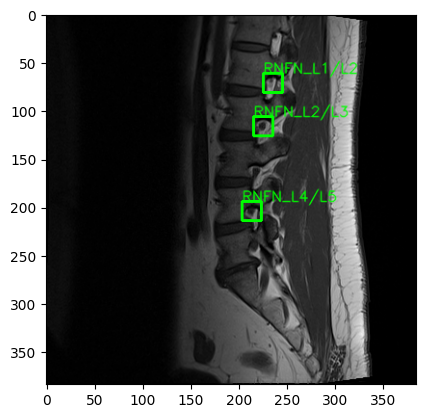

In [20]:
plt.imshow(img)
plt.show()

In [21]:
# label_df[['study_id', 'series_id']].drop_duplicates()

In [22]:
def read_dcm(src_path):
    dicom_data = pydicom.dcmread(src_path)
    image = dicom_data.pixel_array
    image = (image - image.min()) / (image.max() - image.min() +1e-6) * 255
    image = np.stack([image]*3, axis=-1).astype('uint8')
    return image

In [23]:
filtered_df = label_df[label_df.condition.map(lambda x: x in CONDITIONS)]

In [24]:
label2id = {}
id2label = {}
i = 0
for cond in CONDITIONS:
    for level in LEVELS:
        for severity in SEVERITIES:
            cls_ = f"{cond.lower().replace(' ', '_')}_{level}_{severity.lower()}"
            label2id[cls_] = i
            id2label[i] = cls_
            i+=1

In [25]:
id2label

{0: 'spinal_canal_stenosis_l1_l2_normal/mild',
 1: 'spinal_canal_stenosis_l1_l2_moderate',
 2: 'spinal_canal_stenosis_l1_l2_severe',
 3: 'spinal_canal_stenosis_l2_l3_normal/mild',
 4: 'spinal_canal_stenosis_l2_l3_moderate',
 5: 'spinal_canal_stenosis_l2_l3_severe',
 6: 'spinal_canal_stenosis_l3_l4_normal/mild',
 7: 'spinal_canal_stenosis_l3_l4_moderate',
 8: 'spinal_canal_stenosis_l3_l4_severe',
 9: 'spinal_canal_stenosis_l4_l5_normal/mild',
 10: 'spinal_canal_stenosis_l4_l5_moderate',
 11: 'spinal_canal_stenosis_l4_l5_severe',
 12: 'spinal_canal_stenosis_l5_s1_normal/mild',
 13: 'spinal_canal_stenosis_l5_s1_moderate',
 14: 'spinal_canal_stenosis_l5_s1_severe'}

In [26]:
train_df = filtered_df[filtered_df.fold != FOLD]
val_df = filtered_df[filtered_df.fold == FOLD]

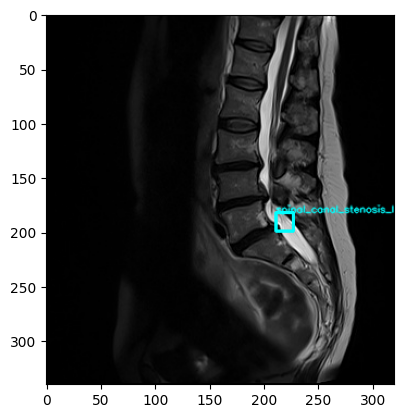

In [27]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/train'
_ANN_DIR = f'{DATA_DIR}/labels/train'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

im = plt.imread(os.path.join(_IM_DIR, name+'.jpg')).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [28]:
# ls data_fold0/labels/val

In [29]:
# os.path.join(_ANN_DIR, name+'.txt')

In [30]:
# cat 'train_fold0/labels/404602713_1230697721_12.txt'

In [31]:
# Install the ultralytics package from GitHub
!pip install git+https://github.com/ultralytics/ultralytics.git@main

  Cloning https://github.com/ultralytics/ultralytics.git (to revision main) to /tmp/pip-req-build-m2fy_qp3
  Running command git clone --filter=blob:none --quiet https://github.com/ultralytics/ultralytics.git /tmp/pip-req-build-m2fy_qp3
  Resolved https://github.com/ultralytics/ultralytics.git to commit efb0c17881eb613e1fe403eb3a629fe19b9b70ae
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for ultralytics: filename=ultralytics-8.2.103-py3-none-any.whl size=875111 sha256=401ce62d9c9b6346ffb1147f07d82f30d017d65a5baa6b2e599413cf81705f1c
  Stored in directory: /tmp/pip-ephem-wheel-cache-sx_cxe7k/wheels/60/db/e5/6abbdd13b4e3d5e2fdcd87690cd8738f842eeb37142fdccb5b
Successfully built ultralytics


In [32]:
for k, v in id2label.items():
    print(f'{k}: {v}')

0: spinal_canal_stenosis_l1_l2_normal/mild
1: spinal_canal_stenosis_l1_l2_moderate
2: spinal_canal_stenosis_l1_l2_severe
3: spinal_canal_stenosis_l2_l3_normal/mild
4: spinal_canal_stenosis_l2_l3_moderate
5: spinal_canal_stenosis_l2_l3_severe
6: spinal_canal_stenosis_l3_l4_normal/mild
7: spinal_canal_stenosis_l3_l4_moderate
8: spinal_canal_stenosis_l3_l4_severe
9: spinal_canal_stenosis_l4_l5_normal/mild
10: spinal_canal_stenosis_l4_l5_moderate
11: spinal_canal_stenosis_l4_l5_severe
12: spinal_canal_stenosis_l5_s1_normal/mild
13: spinal_canal_stenosis_l5_s1_moderate
14: spinal_canal_stenosis_l5_s1_severe


In [33]:
ls

__notebook__.ipynb  data_fold4/


In [34]:
%%writefile yolo_scs.yaml
path: /kaggle/working/data_fold4 # dataset root dir
train: images/train  
val: images/val 
test: images/val 

# Classes
names:
    0: spinal_canal_stenosis_l1_l2_normal/mild
    1: spinal_canal_stenosis_l1_l2_moderate
    2: spinal_canal_stenosis_l1_l2_severe
    3: spinal_canal_stenosis_l2_l3_normal/mild
    4: spinal_canal_stenosis_l2_l3_moderate
    5: spinal_canal_stenosis_l2_l3_severe
    6: spinal_canal_stenosis_l3_l4_normal/mild
    7: spinal_canal_stenosis_l3_l4_moderate
    8: spinal_canal_stenosis_l3_l4_severe
    9: spinal_canal_stenosis_l4_l5_normal/mild
    10: spinal_canal_stenosis_l4_l5_moderate
    11: spinal_canal_stenosis_l4_l5_severe
    12: spinal_canal_stenosis_l5_s1_normal/mild
    13: spinal_canal_stenosis_l5_s1_moderate
    14: spinal_canal_stenosis_l5_s1_severe
  

Writing yolo_scs.yaml


In [35]:
import wandb
from wandb.integration.ultralytics import add_wandb_callback

# 直接使用 WandB API 密钥进行登录
wandb.login(key='259ce53bd0c909534486157b63f028c2975479e2')  # 用你的实际 API 密钥替换此字符串

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


wandb: WARNING This integration is tested and supported for ultralytics v8.0.238 and below.
wandb: WARNING             Please report any issues to https://github.com/wandb/wandb/issues with the tag `yolov8`.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [36]:
# Initialize W&B run
wandb.init(
    project="lsdc_yolov8",
#     name=f"Demo_fold0",
#     tags=["baseline", "search-lr", ],
    group=";".join(CONDITIONS),
#     config={
#         "lr": LR,
#         "model-name":"xtremedistill-trim",
#         "dataset": [
#             "raw_compettion",
#             "MPWare",
#             "Nicholas"
#         ]
#     }
)

wandb: Currently logged in as: majiaqi073 (majiaqi073-zhejiang-university-of-technology). Use `wandb login --relogin` to force relogin
wandb: wandb version 0.18.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade
wandb: Tracking run with wandb version 0.17.4
wandb: Run data is saved locally in /kaggle/working/wandb/run-20240929_170534-xji78rf1
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run dutiful-blaze-51
wandb: ⭐️ View project at https://wandb.ai/majiaqi073-zhejiang-university-of-technology/lsdc_yolov8
wandb: 🚀 View run at https://wandb.ai/majiaqi073-zhejiang-university-of-technology/lsdc_yolov8/runs/xji78rf1


In [37]:
from ultralytics import YOLO


# Initialize YOLO Model
model = YOLO("yolov8m.pt")

# Add W&B callback for Ultralytics
add_wandb_callback(model, enable_model_checkpointing=True)

# Train/fine-tune your model
# At the end of each epoch, predictions on validation batches are logged
# to a W&B table with insightful and interactive overlays for
# computer vision tasks
model.train(project="lsdc_yolov8", data="yolo_scs.yaml", 
            epochs=EPOCHS, imgsz=OD_INPUT_SIZE, batch=BATCH_SIZE)

# Finish the W&B run
wandb.finish()

100%|██████████| 49.7M/49.7M [00:00<00:00, 275MB/s]


Ultralytics YOLOv8.2.103 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolov8m.pt, data=yolo_scs.yaml, epochs=50, time=None, patience=100, batch=64, imgsz=384, save=True, save_period=-1, cache=False, device=None, workers=8, project=lsdc_yolov8, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

100%|██████████| 755k/755k [00:00<00:00, 24.4MB/s]
2024-09-29 17:05:53,400	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-09-29 17:05:54,321	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=15

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1    664320  ultralytics.nn.modules.conv.Conv             [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1   1991808  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 101MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/data_fold4/labels/train... 2016 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2016/2016 [00:01<00:00, 1316.39it/s]

train: New cache created: /kaggle/working/data_fold4/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/working/data_fold4/labels/val... 506 images, 0 backgrounds, 0 corrupt: 100%|██████████| 506/506 [00:00<00:00, 1461.35it/s]

val: New cache created: /kaggle/working/data_fold4/labels/val.cache


Plotting labels to lsdc_yolov8/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000526, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to lsdc_yolov8/train
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50        12G       4.02      6.035      2.066        181        384: 100%|██████████| 32/32 [00:28<00:00,  1.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.16s/it]

                   all        506       1947      0.307      0.238      0.126     0.0358
Ultralytics YOLOv8.2.103 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)


YOLOv8m summary (fused): 218 layers, 25,886,080 parameters, 0 gradients, 78.9 GFLOPs


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      12.1G      1.935      1.816     0.9903        137        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.348      0.324      0.252     0.0998


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      12.1G      1.836      1.541     0.9754        187        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.444      0.486      0.302      0.124


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      12.1G      1.809       1.45     0.9593        146        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.418      0.491      0.445       0.21


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      12.1G      1.782      1.351     0.9507        155        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.521      0.582      0.529      0.221


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      12.1G       1.73      1.326      0.948        145        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        506       1947       0.52      0.571      0.465      0.215


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      12.1G      1.732      1.239     0.9417        142        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.501      0.623      0.503      0.231


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      12.1G      1.725      1.247     0.9398        180        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.507      0.516      0.497       0.23


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      12.1G      1.687      1.233     0.9333        173        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947       0.52      0.643      0.553      0.254


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      12.1G      1.655      1.189     0.9275        208        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.536      0.609      0.522       0.22


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      12.1G      1.684      1.205     0.9317        168        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947       0.49      0.653      0.557      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      12.1G      1.691       1.16     0.9355        231        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.449       0.69      0.557      0.256


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      12.1G      1.632      1.144      0.923        146        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.488      0.604      0.545      0.222


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      12.1G      1.662      1.156      0.929        224        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.514      0.609       0.55      0.264


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      12.1G       1.66      1.158     0.9268        138        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.505      0.614       0.55      0.254


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      12.1G      1.614      1.111     0.9212        188        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947        0.5      0.666       0.59      0.285


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      12.1G      1.603      1.124     0.9189        197        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.531      0.591      0.554      0.267


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      12.1G      1.611      1.126     0.9167        171        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.529      0.652      0.576      0.273


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      12.1G      1.605      1.106     0.9159        143        384: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.477       0.66      0.565      0.274


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      12.1G      1.571       1.09     0.9166        191        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.542      0.615      0.561      0.248


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      12.1G      1.581      1.081     0.9173        143        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        506       1947      0.482      0.675      0.571      0.259


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      12.1G      1.567      1.076     0.9154        203        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        506       1947      0.481      0.687      0.544      0.247


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      12.1G      1.582       1.06      0.921        137        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947       0.45       0.76      0.565      0.251


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      12.1G      1.579      1.027     0.9162        191        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.539      0.623      0.581      0.273


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      12.1G       1.55      1.027     0.9072        177        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.556      0.659      0.596       0.29


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      12.1G      1.546      1.034     0.9056        195        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.14it/s]

                   all        506       1947      0.529      0.709      0.613       0.28


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      12.1G      1.538      1.023     0.9096        168        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.597      0.612      0.595      0.281


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      12.1G      1.531      1.022     0.9074        185        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.482      0.704      0.582      0.276


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      12.1G      1.529       1.02     0.9051        135        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.549       0.62      0.569      0.278


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      12.1G      1.524     0.9874     0.9061        156        384: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]

                   all        506       1947      0.559      0.707      0.574      0.273


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      12.1G      1.515     0.9949     0.9047        156        384: 100%|██████████| 32/32 [00:26<00:00,  1.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.06it/s]

                   all        506       1947      0.555      0.643      0.585       0.29


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      12.1G      1.512     0.9796     0.9017        138        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.522      0.685       0.58       0.28


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      12.1G        1.5     0.9746     0.9036        176        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all        506       1947       0.54      0.666      0.593      0.283


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      12.1G      1.492     0.9737     0.9031        116        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.569      0.665      0.594      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      12.1G      1.484     0.9647     0.8992        205        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.584      0.687      0.587       0.27


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      12.1G      1.478     0.9457     0.8986        172        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.577      0.665      0.605      0.299


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      12.1G      1.457      0.933      0.901        197        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947       0.54      0.747      0.604      0.297


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      12.1G      1.471     0.9275     0.8994        184        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.574      0.688      0.593      0.281


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      12.1G      1.465     0.9288     0.8979        182        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]

                   all        506       1947      0.585      0.673      0.607      0.296


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      12.1G      1.441     0.9287     0.8927        189        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]

                   all        506       1947      0.552      0.694      0.591      0.286


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]

Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      12.1G      1.444     0.8868      0.921        145        384: 100%|██████████| 32/32 [00:27<00:00,  1.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.568      0.688      0.585      0.294


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      12.1G      1.412     0.8684     0.9211        119        384: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.586       0.63      0.609      0.306


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      12.1G      1.386      0.853     0.9118        132        384: 100%|██████████| 32/32 [00:26<00:00,  1.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.65s/it]

                   all        506       1947      0.559      0.654      0.606      0.306


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      12.1G      1.385     0.8398     0.9119        137        384: 100%|██████████| 32/32 [00:26<00:00,  1.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.69s/it]

                   all        506       1947      0.547      0.658      0.576      0.284


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      12.1G      1.379     0.8223     0.9133        113        384: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.538      0.671      0.581      0.291


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      12.1G      1.363     0.8175     0.9135        135        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.516      0.727      0.591      0.289


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      12.1G      1.347     0.8018     0.9068        124        384: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.508      0.777      0.581      0.298


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      12.1G      1.333     0.7971     0.9072        124        384: 100%|██████████| 32/32 [00:26<00:00,  1.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947       0.52      0.728      0.567      0.283


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      12.1G      1.336     0.7877     0.9048        113        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.12it/s]

                   all        506       1947      0.492      0.726      0.565      0.283


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]


      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      12.1G      1.313     0.7831     0.9031        119        384: 100%|██████████| 32/32 [00:26<00:00,  1.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.13it/s]

                   all        506       1947      0.492      0.721       0.57      0.288


Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Generating Visualizations for batch-1/1:   0%|          | 0/122 [00:00<?, ?it/s]


50 epochs completed in 0.872 hours.
Optimizer stripped from lsdc_yolov8/train/weights/last.pt, 52.0MB
Optimizer stripped from lsdc_yolov8/train/weights/best.pt, 52.0MB

Validating lsdc_yolov8/train/weights/best.pt...
Ultralytics YOLOv8.2.103 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Model summary (fused): 218 layers, 25,848,445 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:09<00:00,  2.43s/it]


                   all        506       1947      0.559      0.654      0.606      0.307
spinal_canal_stenosis_l1_l2_normal/mild        366        366      0.811      0.899      0.824      0.399
spinal_canal_stenosis_l1_l2_moderate         10         10       0.34        0.5      0.311      0.168
spinal_canal_stenosis_l1_l2_severe          4          4      0.307       0.25      0.385     0.0927
spinal_canal_stenosis_l2_l3_normal/mild        347        347      0.797      0.905      0.804      0.388
spinal_canal_stenosis_l2_l3_moderate         27         27      0.407      0.593      0.451       0.27
spinal_canal_stenosis_l2_l3_severe         11         11      0.288      0.224      0.412      0.214
spinal_canal_stenosis_l3_l4_normal/mild        326        326      0.794      0.913      0.859      0.429
spinal_canal_stenosis_l3_l4_moderate         46         46      0.521      0.565      0.479      0.251
spinal_canal_stenosis_l3_l4_severe         22         22      0.577      0.681    

Generating Visualizations for batch-1/1:   0%|          | 0/128 [00:00<?, ?it/s]

Speed: 0.1ms preprocess, 4.2ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to lsdc_yolov8/train


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:                  lr/pg0 ▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg1 ▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:                  lr/pg2 ▃▆████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
wandb:        metrics/mAP50(B) ▁▃▄▆▆▆▆▇▇▇▇▇█▇▇▇▇▇▇████▇███████████▇██▇█
wandb:     metrics/mAP50-95(B) ▁▃▃▅▆▆▆▇▇▇▆▇▇▇▇▇▇▆▇▇▇▇▇▇█▇▇███▇████▇██▇█
wandb:    metrics/precision(B) ▁▂▄▄▆▆▆▆▅▄▅▆▆▆▆▅▅▅▄▇▆█▅▇▇▆▇▇█▇▇█▇█▇▇▆▆▆▇
wandb:       metrics/recall(B) ▁▂▄▄▅▆▅▆▆▇▆▆▇▆▆▆▇▇█▆▇▆▇▆▆▇▇▇▇█▇▇▇▆▆▆▇█▇▆
wandb:            model/GFLOPs ▁
wandb:        model/parameters ▁
wandb: model/speed_PyTorch(ms) ▁
wandb:          train/box_loss █▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/cls_loss █▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:          train/dfl_loss █▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
wandb:            val/box_loss █▃▃▂▂▂▂▂▂▂▄▁▁▁▂▂▂▃▂▁▂▂▁▁▁▂▂▁▂▁▂▂▁▂▂

spinal_canal_stenosis_l1_l2_normal/mild
spinal_canal_stenosis_l2_l3_normal/mild
spinal_canal_stenosis_l3_l4_normal/mild
spinal_canal_stenosis_l4_l5_normal/mild
spinal_canal_stenosis_l5_s1_normal/mild


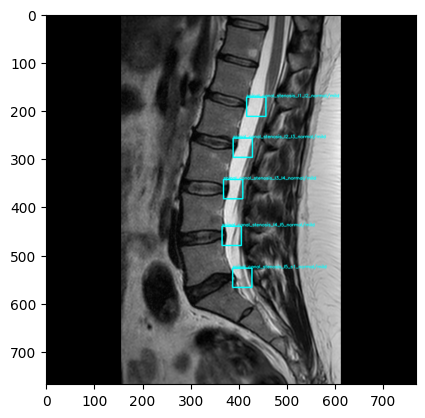

In [38]:
# # test generated annotations

_IM_DIR = f'{DATA_DIR}/images/val'
_ANN_DIR = f'{DATA_DIR}/labels/val'
name = np.random.choice(os.listdir(_IM_DIR))[:-4]

path = os.path.join(_IM_DIR, name+'.jpg')

im = plt.imread(path).copy()
H,W = im.shape[:2]
anns = np.loadtxt(os.path.join(_ANN_DIR, name+'.txt')).reshape(-1, 5)

for _cls, x,y,w,h in anns.tolist():
    x *= W
    y *= H
    w *= W
    h *= H
    x1 = int(x-w/2)
    x2 = int(x+w/2)
    y1 = int(y-h/2)
    y2 = int(y+h/2)
    label = id2label[_cls]
    print(label)
    
#     if _cls == 0:
#         c = (255,0,0)
#     elif _cls == 1:
#         c = (0,255,0)
#     else:
#         c = (255,255,0)
    c = (0,255,255)

    im = cv2.rectangle(im, (x1,y1), (x2,y2), c, 2)
    cv2.putText(im, label, (x1,y1), fontFace, 0.3, c, 1, cv2.LINE_AA)


plt.imshow(im)

In [39]:
# Initialize YOLO Model
model = YOLO(glob.glob("lsdc_yolov8/*/weights/best.pt")[0])

# Add W&B callback for Ultralytics
# add_wandb_callback(model, enable_model_checkpointing=True)

# Perform prediction which automatically logs to a W&B Table
# with interactive overlays for bounding boxes, segmentation masks
out = model.predict([path], save=True, conf=0.2)

# Finish the W&B run
wandb.finish()


0: 384x384 1 spinal_canal_stenosis_l1_l2_normal/mild, 1 spinal_canal_stenosis_l2_l3_normal/mild, 1 spinal_canal_stenosis_l3_l4_normal/mild, 1 spinal_canal_stenosis_l4_l5_normal/mild, 1 spinal_canal_stenosis_l5_s1_normal/mild, 10.3ms
Speed: 2.4ms preprocess, 10.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 384)
Results saved to runs/detect/predict


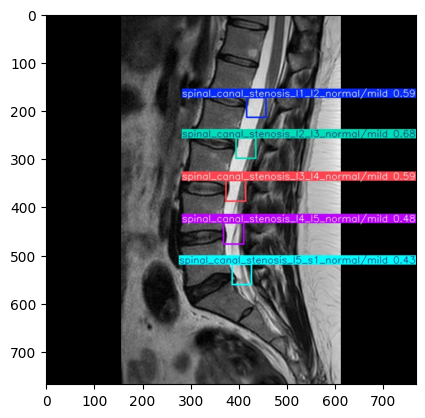

In [40]:
im = plt.imread(glob.glob(f'{out[0].save_dir}/*.jpg')[0])
plt.imshow(im)